## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
def preproc_x(x):
    x = x.astype("float32")
    x = x.reshape(x.shape[0],-1)
    x = scaler.fit_transform(x)
    return x

def preproc_y(y):
    y = keras.utils.to_categorical(y, num_classes=10)
    return y      

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
"""
建立你的神經網路
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, layer_output_units, output_units, regularizer=None, dropout_ratio=None, isBN=False):
    model = Sequential()
    for i, untis in enumerate(layer_output_units):  
        if i == 0:
            model.add(Dense(units=untis, 
                            input_dim=input_dim,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())
        else:
            model.add(Dense(units=untis,
                            kernel_initializer='normal',
                            kernel_regularizer=regularizer, 
                            activation='relu'))
            if isBN:
                model.add(BatchNormalization())

    if dropout_ratio:
        model.add(Dropout(dropout_ratio))
        
    model.add(Dense(units=output_units,
                kernel_initializer='normal', 
                activation='softmax'))
    return model  

In [6]:
"""
訓練模型
"""
def complie_train_model(model, optimizer, epochs, batch_size, callbacks,   x_train, y_train, x_test, y_test):
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer= optimizer)
    model.fit(x_train, y_train, 
          epochs= epochs, 
          batch_size=batch_size, 
          validation_data=(x_test, y_test), 
          callbacks=callbacks, 
          shuffle=True)
    return model

In [27]:
"""
以視覺畫方式檢視訓練過程
"""
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_train_history(results, title=""):
    for i, result in enumerate(results):
        history = result["model"].history.history
        tag = "({})".format(result["tag"])
        df_acc = pd.DataFrame({"acc"+tag:history["acc"], "val_acc"+tag:history["val_acc"]})
        df_loss = pd.DataFrame({"loss"+tag:history["loss"], "val_loss"+tag:history["val_loss"]})
        if i ==0:
            df_acc_results = df_acc.copy()
            df_loss_results = df_loss.copy()
        else:
            df_acc_results= pd.concat([df_acc_results, df_acc], axis=1)
            df_loss_results= pd.concat([df_loss_results, df_loss], axis=1)    

    fig, ax = plt.subplots(1,2, figsize=(18,5))
    styles = ['bs-','ro-','y^-', 'g--']    
    g1 = df_acc_results.plot.line(style=styles, ax =ax[0])
    g1.set_xlabel("Epoch")
    g1.set_ylabel("Acc") 
    g1.set_title(title) 
    
    g2 = df_loss_results.plot.line(style=styles, ax =ax[1])
    g2.set_xlabel("Epoch")
    g2.set_ylabel("Loss") 
    g2.set_title(title) 
    return df_acc_results, df_loss_results, g1, g2

In [18]:
"""
設定 callbacks
"""

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def setup_callbacks(ismodelckpt=False, isearlystop=False, isreducelr = False, 
                    monitor="val_acc", save_only="best", patience=5, min_lr= 1e-12, factor=0.5 ):
    cbs=list()
    
    if ismodelckpt:
        modelckpt = ModelCheckpoint(filepath="./tmp.h5",
                                    monitor=monitor, 
                                    save_best_only="best" in save_only,
                                    save_weights_only="weights" in save_only)
        cbs.append(modelckpt)
    if isearlystop:
        earlystop = EarlyStopping(monitor=monitor, 
                                  patience=patience, 
                                  verbose=1)
        cbs.append(earlystop)
    if isreducelr:
        reducelr = ReduceLROnPlateau(factor=factor, 
                              min_lr=min_lr, 
                              monitor=monitor, 
                              patience=patience, 
                              verbose=1)
        cbs.append(reducelr)
    return cbs

In [22]:
EPOCHS = 50
BATCH_SIZE=1024
L2_EXP = 1e-3
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
DROPOUT_EXP = 0.25
MIN_LRS=[(1e-3,0.2), (1e-12, 0.5)]

In [23]:
"""
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = list()

for i, mlr in enumerate(MIN_LRS):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=regularizer, dropout_ratio=DROPOUT_EXP, isBN=True)
    optimizer =  keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    callbacks = setup_callbacks(isreducelr=True, min_lr= mlr[0], factor=mlr[1])
    model = complie_train_model(model=model, optimizer=optimizer,  epochs=EPOCHS , batch_size=BATCH_SIZE, callbacks=callbacks, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    results.append({"tag": "mlr={},{}".format(mlr[0], mlr[1]), "model":model})

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 30s 596us/step - loss: 36.7202 - acc: 0.1857 - val_loss: 36.1265 - val_acc: 0.2808
Epoch 2/50
50000/50000 [==============================] - 19s 377us/step - loss: 35.6423 - acc: 0.2972 - val_loss: 35.0838 - val_acc: 0.3396
Epoch 3/50
50000/50000 [==============================] - 19s 371us/step - loss: 34.6311 - acc: 0.3367 - val_loss: 34.1119 - val_acc: 0.3638
Epoch 4/50
50000/50000 [==============================] - 18s 368us/step - loss: 33.6769 - acc: 0.3591 - val_loss: 33.1791 - val_acc: 0.3821
Epoch 5/50
50000/50000 [==============================] - 19s 380us/step - loss: 32.7526 - acc: 0.3730 - val_loss: 32.2725 - val_acc: 0.3967
Epoch 6/50
50000/50000 [==============================] - 18s 365us/step - loss: 31.8553 - acc: 0.3897 - val_loss: 31.3883 - val_acc: 0.4039
Epoch 7/50
50000/50000 [==============================] - 19s 380us/step - loss: 30.9789 - acc: 0.3962 -

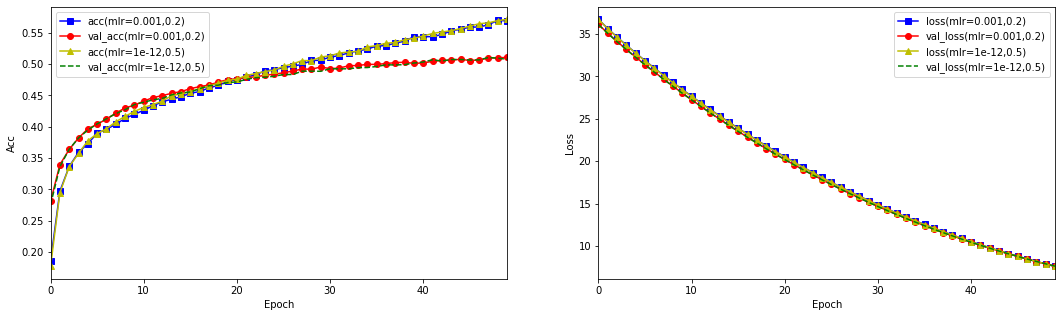

In [24]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results, g1, g2 = show_train_history(results)

In [25]:
"""
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = list()

for i, mlr in enumerate(MIN_LRS):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    regularizer = keras.regularizers.l1_l2(l1=L2_EXP, l2=L2_EXP)
    model = build_mlp(input_dim=x_train.shape[1], layer_output_units=[256,128], output_units=10, regularizer=regularizer, dropout_ratio=DROPOUT_EXP, isBN=True)
    optimizer =  keras.optimizers.Adam(lr=LEARNING_RATE)
    callbacks = setup_callbacks(isreducelr=True, min_lr= mlr[0], factor=mlr[1])
    model = complie_train_model(model=model, optimizer=optimizer,  epochs=EPOCHS , batch_size=BATCH_SIZE, callbacks=callbacks, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
    results.append({"tag": "mlr={},{}".format(mlr[0], mlr[1]), "model":model})

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 19s 381us/step - loss: 23.4945 - acc: 0.3488 - val_loss: 12.7563 - val_acc: 0.3845 23s - loss: 32.9747 -  - ETA: 11s - loss: 29.5743 - acc: 0.309 - ETA: 10s - loss: 29.2830 - acc: 0.311 - ETA: 9 - ETA: 2s - loss: 24.8147 - acc: 0. - ETA: 1s - loss: 24.3507 - acc: 0. - ETA: 0s - loss: 23.8980 - acc: 0.
Epoch 2/50
50000/50000 [==============================] - 12s 232us/step - loss: 8.0981 - acc: 0.4267 - val_loss: 5.2774 - val_acc: 0.3864 8s - loss: 11.0972 - acc:  - ETA: 7s -  - ETA: 2s - loss: 9.0401 - ac - ETA: 1s - loss: 8.4017 - acc: 0
Epoch 3/50
50000/50000 [==============================] - 11s 224us/step - loss: 4.0030 - acc: 0.4358 - val_loss: 3.4262 - val_acc: 0.3942oss: 4.6932 - acc: 0.4 - ETA: 6s - loss: 4.6120 - - ETA: 3s - loss: 4.3390  - ETA: 1s - loss: 4.1041 - acc:
Epoch 4/50
50000/50000 [==============================] - 11s 221us/step - loss: 2.9810 - acc: 0.433

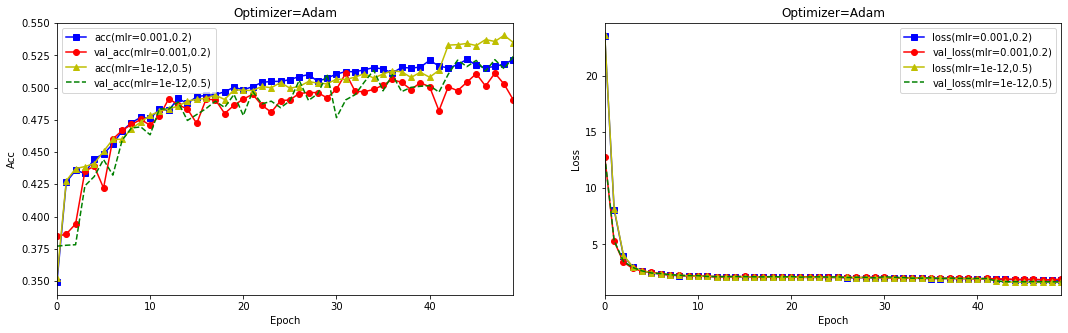

In [28]:
"""
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline

df_acc_results, df_loss_results, g1, g2 = show_train_history(results, "Optimizer=Adam")

In [ ]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = []
redice_lr_patient = []

In [ ]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()